# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


In [5]:
import numpy as np
import random
import copy
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [7]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        model = torch.nn.Sequential(
            self.fc1,
#             nn.Dropout(p=0.2),
            nn.ReLU(),
            self.fc2,
            nn.Tanh()
        )
        
        return model(state)

In [8]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=64, fc3_units=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)

In [9]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 1024       # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 3e-3        # learning rate of the critic
WEIGHT_DECAY = 0.0      # L2 weight decay

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done, step):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state[0], action[0], reward[0], next_state[0], done[0])
        self.memory.add(state[1], action[1], reward[1], next_state[1], done[1])

        # Learn, if enough samples are available in memory
        if step%2 == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [11]:
agent = Agent(state_size=24, action_size=2, random_seed=4)

def run_episodes(episodes=5000, steps=1000):
    q = deque(maxlen = 100)
    reward_list = []
    env_info = env.reset(train_mode=True)[brain_name]          # reset the environment
    
    for episode in range(episodes):                            # play game for n episodes
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        
        for step in range(steps):          
            actions = np.random.randn(num_agents, action_size)
            
            actions[0] = agent.act(states[0])                  # select an action
            actions[1] = agent.act(states[1])                  
            
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send actions to environment
            
            next_states = env_info.vector_observations         # get next state
            rewards = env_info.rewards                         # get rewards
            dones = env_info.local_done                        
            
            agent.step(states, actions, rewards, next_states, dones, step)
            
            scores += rewards                                  
            states = next_states                               # roll over states to next time step
            score = np.sum(scores)

            if np.any(dones):                                  # exit loop if episode finished
                break

        reward_list.append(score)
        q.append(score)
        
        if episode % 10 == 0:
            avg = np.mean(q)
            print('Reward: ' + str(score) + ' episode ' + str(episode) + '/' + str(episodes))
            print('Avg of last 100 episode: {}'.format(avg))
        
        if((len(q) == 100 and avg >= 0.5) or episode == episodes-1):
            print('Environment solved')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
        
    return reward_list

scores = run_episodes()

Reward: -0.00999999977648 episode 0/5000
Avg of last 100 episode: -0.009999999776482582
Reward: -0.00999999977648 episode 10/5000
Avg of last 100 episode: -0.009999999776482582
Reward: -0.00999999977648 episode 20/5000
Avg of last 100 episode: -0.009999999776482582
Reward: -0.00999999977648 episode 30/5000
Avg of last 100 episode: -0.009999999776482582
Reward: -0.00999999977648 episode 40/5000
Avg of last 100 episode: -0.009999999776482582
Reward: -0.00999999977648 episode 50/5000
Avg of last 100 episode: -0.0060784310905956755
Reward: -0.00999999977648 episode 60/5000
Avg of last 100 episode: -0.006721311203036152
Reward: -0.00999999977648 episode 70/5000
Avg of last 100 episode: -0.007183098326056776
Reward: -0.00999999977648 episode 80/5000
Avg of last 100 episode: -0.007530863937220455
Reward: -0.00999999977648 episode 90/5000
Avg of last 100 episode: -0.00780219754593058
Reward: -0.00999999977648 episode 100/5000
Avg of last 100 episode: -0.00799999974668026
Reward: -0.00999999977

Reward: -0.00999999977648 episode 920/5000
Avg of last 100 episode: -0.009999999776482582
Reward: -0.00999999977648 episode 930/5000
Avg of last 100 episode: -0.009999999776482582
Reward: -0.00999999977648 episode 940/5000
Avg of last 100 episode: -0.009999999776482582
Reward: -0.00999999977648 episode 950/5000
Avg of last 100 episode: -0.009999999776482582
Reward: -0.00999999977648 episode 960/5000
Avg of last 100 episode: -0.009999999776482582
Reward: -0.00999999977648 episode 970/5000
Avg of last 100 episode: -0.009999999776482582
Reward: -0.00999999977648 episode 980/5000
Avg of last 100 episode: -0.009999999776482582
Reward: -0.00999999977648 episode 990/5000
Avg of last 100 episode: -0.009999999776482582
Reward: 0.0900000017136 episode 1000/5000
Avg of last 100 episode: -0.008999999761581421
Reward: -0.00999999977648 episode 1010/5000
Avg of last 100 episode: -0.008999999761581421
Reward: -0.00999999977648 episode 1020/5000
Avg of last 100 episode: -0.008999999761581421
Reward: -

Reward: -0.00999999977648 episode 1840/5000
Avg of last 100 episode: 0.024800000749528407
Reward: 0.0900000017136 episode 1850/5000
Avg of last 100 episode: 0.026900000777095555
Reward: 0.0900000017136 episode 1860/5000
Avg of last 100 episode: 0.027900000791996716
Reward: 0.0900000017136 episode 1870/5000
Avg of last 100 episode: 0.031900000851601364
Reward: 0.0900000017136 episode 1880/5000
Avg of last 100 episode: 0.03590000091120601
Reward: 0.0800000019372 episode 1890/5000
Avg of last 100 episode: 0.04070000099018216
Reward: 0.0900000017136 episode 1900/5000
Avg of last 100 episode: 0.04770000109449029
Reward: -0.00999999977648 episode 1910/5000
Avg of last 100 episode: 0.051700001154094934
Reward: -0.00999999977648 episode 1920/5000
Avg of last 100 episode: 0.048700001109391454
Reward: 0.0900000017136 episode 1930/5000
Avg of last 100 episode: 0.0527000011689961
Reward: -0.00999999977648 episode 1940/5000
Avg of last 100 episode: 0.053700001183897256
Reward: -0.00999999977648 epi

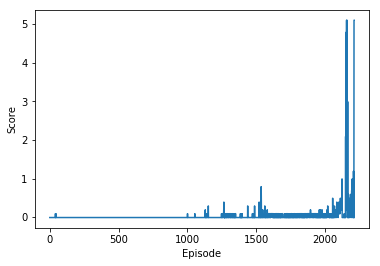

In [12]:
fig = plt.figure()
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

When finished, you can close the environment.

In [13]:
env.close()